### About this notebook

Create a test set for demultiplexing.

1 sample, 1 construct, 2 groups of mutations, one has 2 mutations and the other has 1, 10 reads, 100nt. 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
 
import sys, os

try:
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(__file__)), '../..')))
except:
    __file__ = os.path.join(os.getcwd(),'make_demultiplexing_files.ipynb')
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(__file__)), '../..')))
    
import numpy as np
import dreem 
import dreem.util as util
import pandas as pd
import os

### Create test files for `test set 1`
- library
- pair of fastq files

In [2]:
%reload_ext autoreload

sample_name = 'test_set_1'
number_of_constructs = 2
number_of_reads = [10]*number_of_constructs
mutations = [[[25]]*4+[[50,75]]*(n-4) for n in number_of_reads]
length = 100
sequences = [[util.create_sequence(length)]*number_of_reads[k] for k in range(number_of_constructs)]
insertions = [[[]]*n for n in number_of_reads]
deletions = [[[]]*n for n in number_of_reads]
constructs = ['construct_{}'.format(i) for i in range(number_of_constructs)]
barcode_start = 10
barcodes = [util.generate_barcodes(8, n, 3) for n in number_of_reads]
sections_start = [[0, 25, 50, 75]]*number_of_constructs
sections_end = [[25, 50, 75, 99]]*number_of_constructs
sections = [['{}_{}'.format(ss, se) for ss,se in zip(sections_start[n], sections_end[n])] for n in range(number_of_constructs)]

sample_profile = util.make_sample_profile(constructs, sequences, number_of_reads, mutations, insertions, deletions, sections=sections, section_start=sections_start, section_end=sections_end, barcodes=barcodes, barcode_start=barcode_start)
test_files_dir = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(__file__)),  '../..', 'test', 'test_files'))

inputs = ['fastq','library']
outputs = ['demultiplexed_fastq']
util.generate_files(sample_profile, 'demultiplexing', inputs, outputs, test_files_dir, sample_name)


67
0.36224794387817383 [ms]


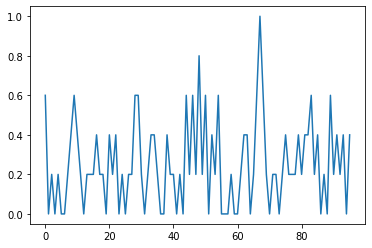

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

base_to_vector = {
    "A": [1, 0, 0, 0],
    "T": [0, 1, 0, 0],
    "C": [0, 0, 1, 0],
    "G": [0, 0, 0, 1]
}

ntry = 1000

# Create random sequences and barcodes
seqs = []
barcodes = []
for i in range(ntry):
    seq = util.create_sequence(100)
    barcode = util.create_sequence(5)

    barcode_start = np.random.randint(0, 90)

    seq = seq[:barcode_start] + barcode + seq[barcode_start+len(barcode):]

    # print(barcode)
    # print(seq)

    seq = [ base_to_vector[base] for base in seq]
    seq = np.array(seq).T

    barcode = [ base_to_vector[base] for base in barcode]
    barcode = np.array(barcode).T

    seqs.append(seq)
    barcodes.append(barcode)

# Compute correlation and time it
now = time.time()
for i in range(ntry):

    corr = signal.correlate(seqs[i], barcodes[i], mode="valid", method="auto").squeeze()/barcode.shape[1]

    np.argmax(corr)

plt.plot(corr)
print(np.argmax(corr))
print(time.time()-now, "[ms]")